In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [36]:
sns.set(style="whitegrid")

Load data

In [37]:

df = pd.read_csv("analyticsvidhya_courses.csv")

Standardize column names

In [38]:

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Columns:", df.columns.tolist())
# Expected: ['title','platform','category','price','duration','difficulty','instructor','rating','learners_/_reviews']

Columns: ['title', 'platform', 'category', 'price', 'duration', 'difficulty', 'instructor', 'rating', 'learners_/_reviews']


 Preprocessing Function


In [39]:

def preprocess_courses(df):
    # Duration → hours
    def convert_duration_to_hours(x):
        if pd.isnull(x):
            return None
        x = str(x).lower().strip()
        if "hour" in x:
            num = re.findall(r"\d+", x)
            return float(num[0]) if num else None
        elif "min" in x:
            num = re.findall(r"\d+", x)
            return float(num[0]) / 60 if num else None
        return None

    if "duration" in df.columns:
        df["duration_hours"] = df["duration"].apply(convert_duration_to_hours)

    # Reviews → numeric (safe)
    if "learners_/_reviews" in df.columns:
        df["reviews"] = (
            df["learners_/_reviews"]
            .astype(str)
            .str.replace(",", "", regex=True)
            .str.extract(r"(\d+)")
            .astype(float)
            .fillna(0)  # replace NaN with 0
        )

    # Rating
    if "rating" in df.columns:
        df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

    # Price
    if "price" in df.columns:
        df["price_clean"] = (
            df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
        )
        df["price_clean"] = pd.to_numeric(df["price_clean"], errors="coerce").fillna(0)

    # Difficulty
    if "difficulty" in df.columns:
        df["difficulty"] = df["difficulty"].astype(str).str.strip().str.title()

    return df

In [40]:
df = preprocess_courses(df)


 Univariate Analysis 

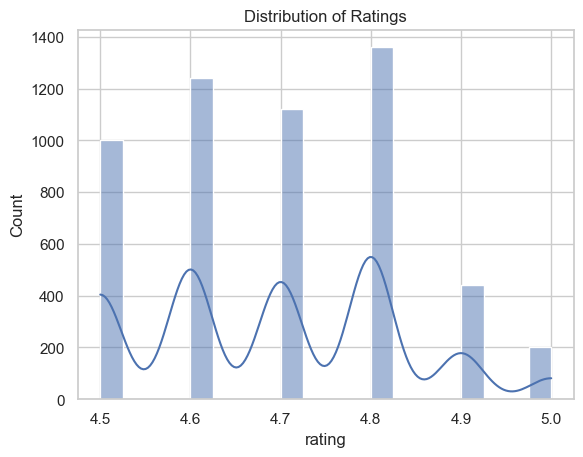

In [41]:

plt.figure()
sns.histplot(df["rating"], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.show()

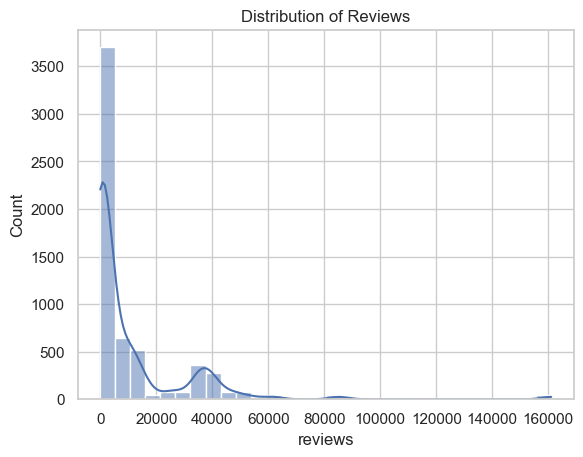

In [42]:
plt.figure()
sns.histplot(df["reviews"], bins=30, kde=True)
plt.title("Distribution of Reviews")
plt.show()

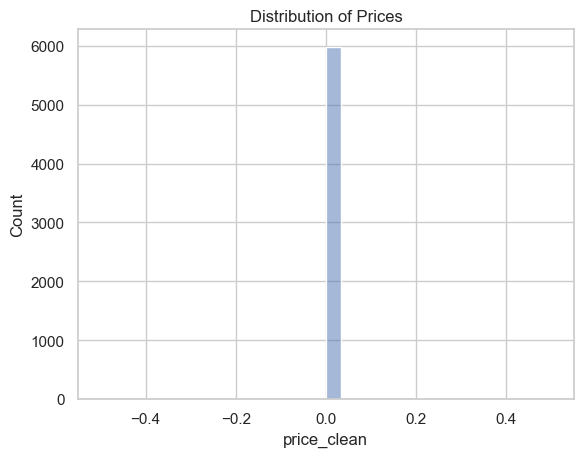

In [43]:
plt.figure()
sns.histplot(df["price_clean"], bins=30, kde=True)
plt.title("Distribution of Prices")
plt.show()

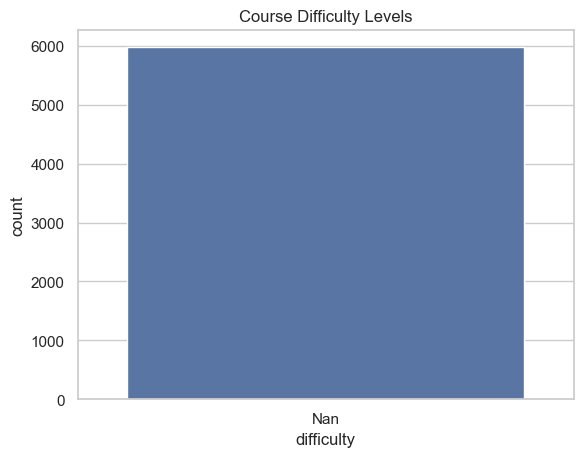

In [44]:
plt.figure()
sns.countplot(x="difficulty", data=df)
plt.title("Course Difficulty Levels")
plt.show()


Bivariate Analysis

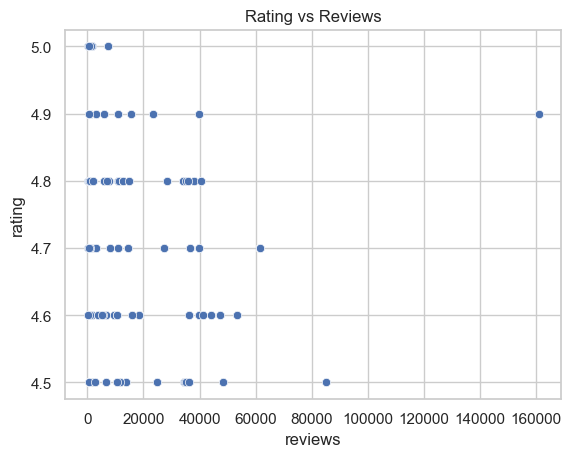

In [45]:


plt.figure()
sns.scatterplot(x="reviews", y="rating", data=df)
plt.title("Rating vs Reviews")
plt.show()

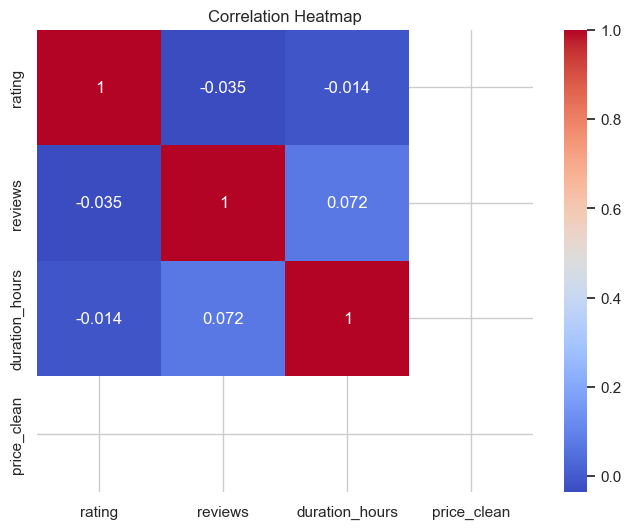

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["rating", "reviews", "duration_hours", "price_clean"]].corr(),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation Heatmap")
plt.show()

 Multivariate Analysis


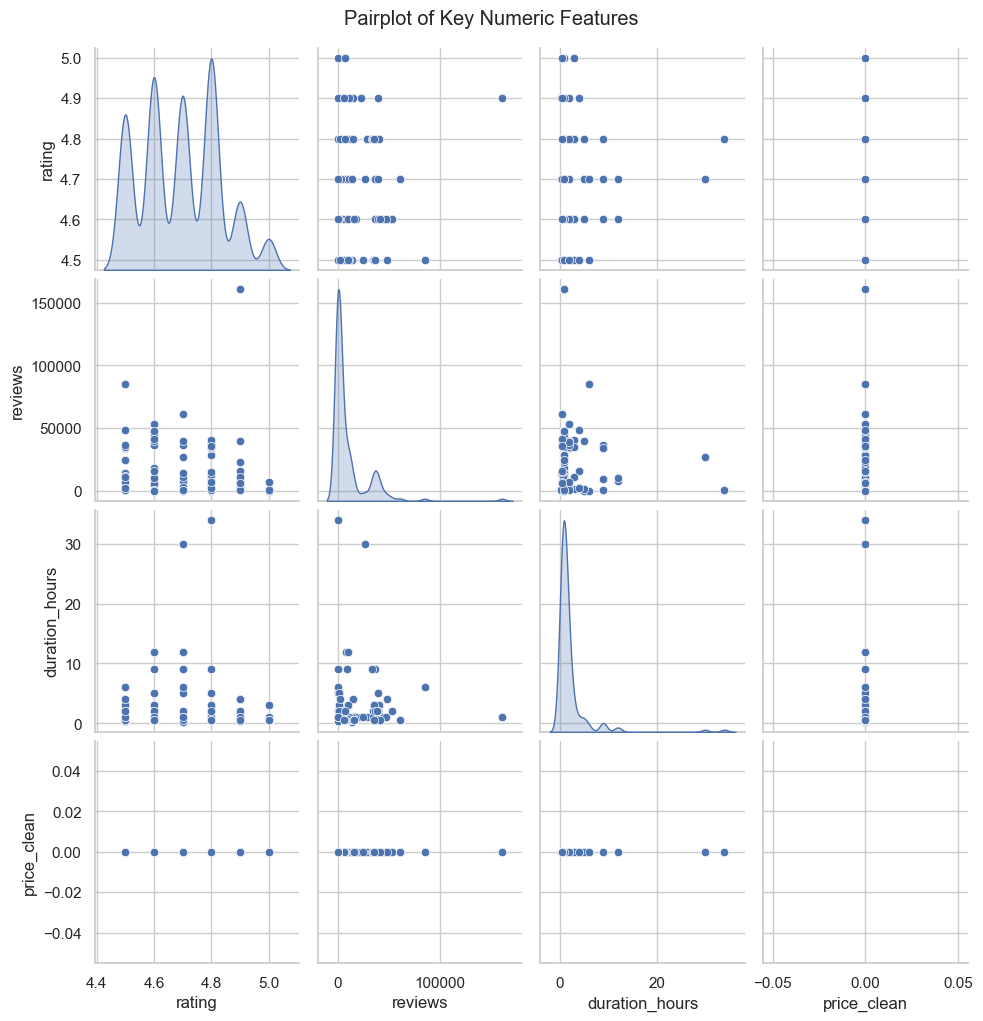

In [47]:
# Pairplot: visualize pairwise relationships across numeric features
sns.pairplot(
    df[["rating", "reviews", "duration_hours", "price_clean"]], diag_kind="kde"
)
plt.suptitle("Pairplot of Key Numeric Features", y=1.02)
plt.show()

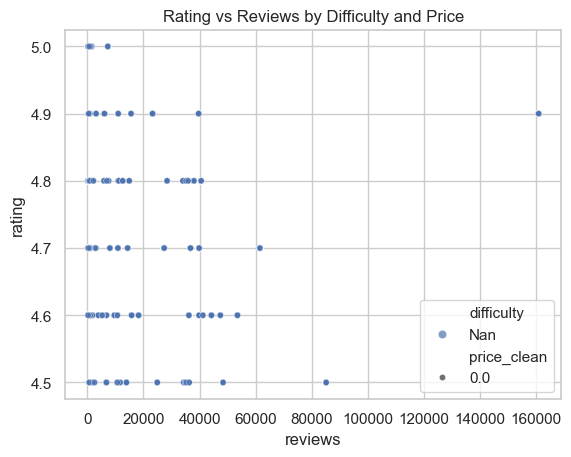

In [48]:
# Multivariate scatterplot: reviews vs rating, colored by difficulty
plt.figure()
sns.scatterplot(
    x="reviews",
    y="rating",
    hue="difficulty",
    size="price_clean",
    sizes=(20, 200),
    alpha=0.7,
    data=df,
)
plt.title("Rating vs Reviews by Difficulty and Price")
plt.show()

C:\Users\rahul\AppData\Local\Temp\ipykernel_20772\3212931945.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="platform", y="rating", hue="difficulty", data=df, ci=None)


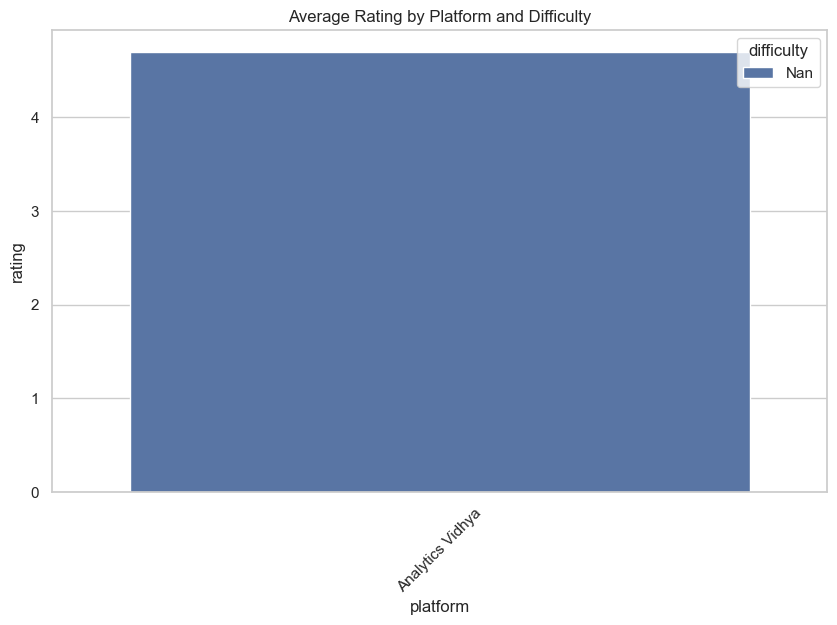

In [49]:
# Grouped barplot: average rating by platform and difficulty
plt.figure(figsize=(10, 6))
sns.barplot(x="platform", y="rating", hue="difficulty", data=df, ci=None)
plt.title("Average Rating by Platform and Difficulty")
plt.xticks(rotation=45)
plt.show()

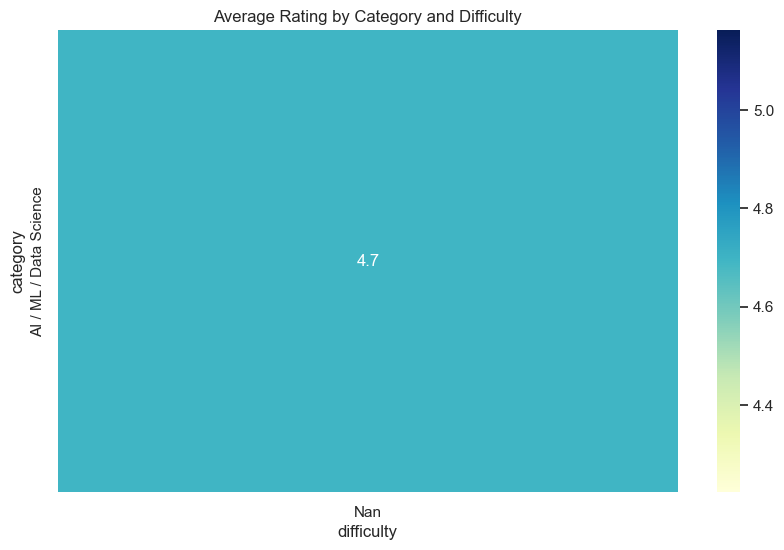

In [50]:
# Pivot heatmap: average rating by category and difficulty
pivot = df.pivot_table(
    values="rating", index="category", columns="difficulty", aggfunc="mean"
)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Average Rating by Category and Difficulty")
plt.show()

Success Definition

In [51]:

df["success"] = (
    (df["rating"] >= 4.5) & (df["reviews"] > df["reviews"].median())
).astype(int)

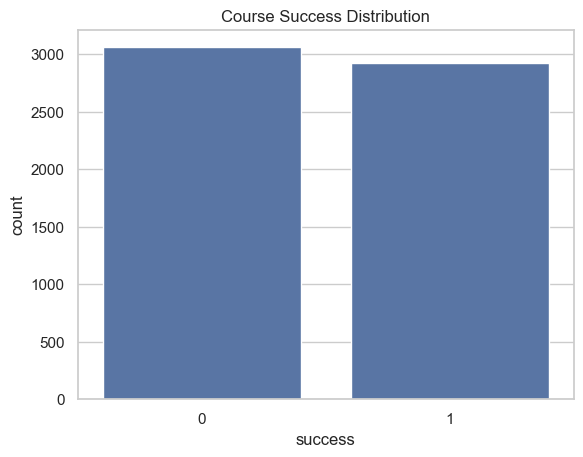

In [52]:
plt.figure()
sns.countplot(x="success", data=df)
plt.title("Course Success Distribution")
plt.show()

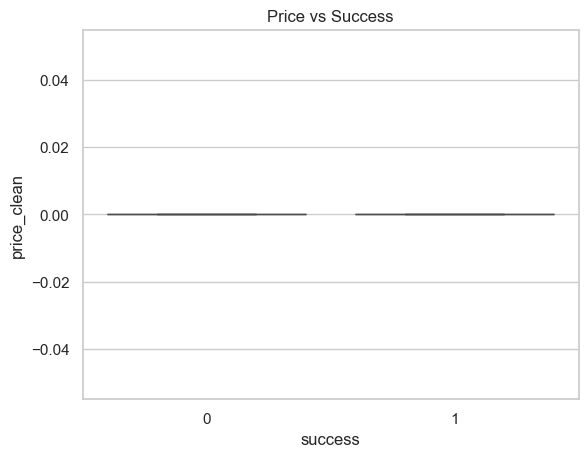

In [53]:
plt.figure()
sns.boxplot(x="success", y="price_clean", data=df)
plt.title("Price vs Success")
plt.show()

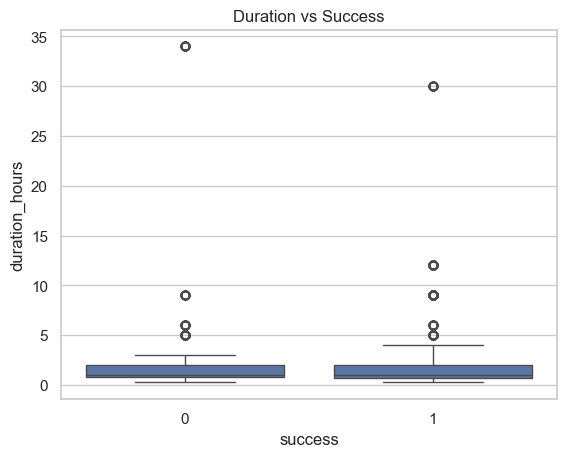

In [54]:
plt.figure()
sns.boxplot(x="success", y="duration_hours", data=df)
plt.title("Duration vs Success")
plt.show()

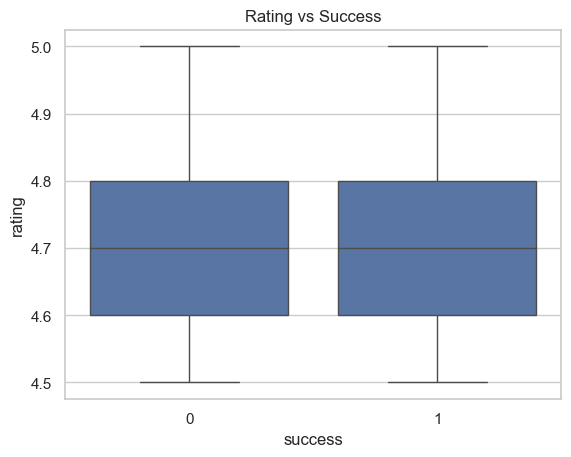

In [55]:
plt.figure()
sns.boxplot(x="success", y="rating", data=df)
plt.title("Rating vs Success")
plt.show()


Feature Importance with Random Forest


In [56]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [57]:
importances = None

In [58]:

features = ["rating", "reviews", "duration_hours", "price_clean", "difficulty"]
X = df[features].copy()

In [59]:
# Encode categorical 'difficulty'
if "difficulty" in X.columns:
    le = LabelEncoder()
    X["difficulty"] = le.fit_transform(X["difficulty"].astype(str))

In [60]:
y = df["success"]

In [61]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

In [64]:
print("\nRandom Forest Feature Importances:")
print(importance_df)


Random Forest Feature Importances:
          Feature  Importance
1         reviews    0.891772
0          rating    0.055076
2  duration_hours    0.053152
3     price_clean    0.000000
4      difficulty    0.000000


C:\Users\rahul\AppData\Local\Temp\ipykernel_20772\4201406077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


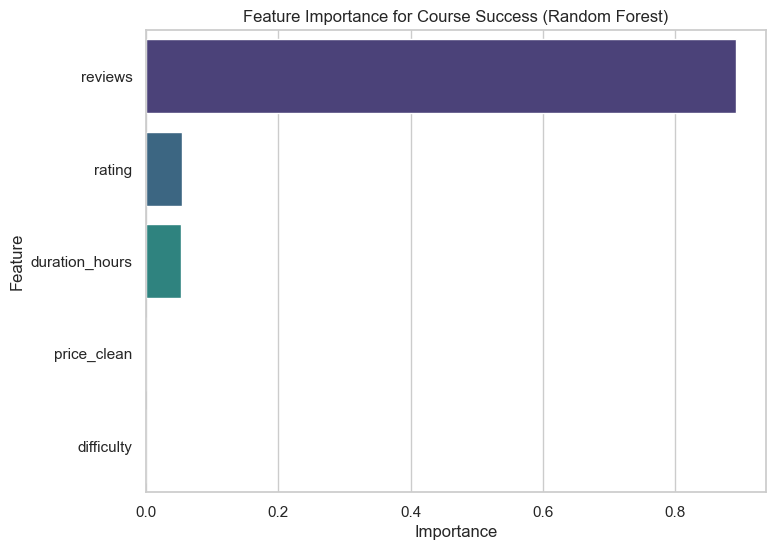

In [65]:
# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance for Course Success (Random Forest)")
plt.show()